In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [3]:
# ODE definition into a system of first-order equations
def forced_rhs(t, y, gamma, w0, F, Omega):
    u, v = y
    du_dt = v
    dv_dt = -2.0 * gamma * v - (w0**2) * u + F * np.cos(Omega * t)
    return [du_dt, dv_dt]

In [4]:
# Data generation
def make_data_forced(
    n_systems=300,      # number of different parameter sets
    num_points=200,     # time points per trajectory
    t_max=4 * np.pi
):

    # Initial conditions
    u0_all = np.random.uniform(-1.5, 1.5, size=(n_systems, 1))
    v0_all = np.random.uniform(-1.0, 1.0, size=(n_systems, 1))

    # Natural frequency and damping (under-damped)
    w0_all = np.random.uniform(0.8, 2.0, size=(n_systems, 1))
    gamma_frac = np.random.uniform(0.05, 0.7, size=(n_systems, 1))
    gamma_all = gamma_frac * w0_all

    # Forcing amplitude and frequency
    F_all     = np.random.uniform(0.2, 1.0, size=(n_systems, 1))
    Omega_all = np.random.uniform(0.5, 2.5, size=(n_systems, 1))

    # Common time grid
    t_grid = np.linspace(0.0, t_max, num_points).reshape(-1, 1)

    X_list = []
    y_list = []

    for u0, v0, w0, gamma, F, Omega in zip(
        u0_all, v0_all, w0_all, gamma_all, F_all, Omega_all
    ):
        sol = solve_ivp(
            fun=lambda tau, y: forced_rhs(tau, y, float(gamma), float(w0), float(F), float(Omega)),
            t_span=(0.0, float(t_grid[-1, 0])),
            y0=[float(u0), float(v0)],
            t_eval=t_grid.flatten(),
            method="RK45",
            rtol=1e-8,
            atol=1e-8,
        )
        u_traj = sol.y[0].reshape(-1, 1)  # (num_points, 1)

        U0    = np.full_like(t_grid, u0)
        V0    = np.full_like(t_grid, v0)
        W0    = np.full_like(t_grid, w0)
        G     = np.full_like(t_grid, gamma)
        F_arr = np.full_like(t_grid, F)
        Om    = np.full_like(t_grid, Omega)

        X_traj = np.hstack([U0, V0, W0, G, F_arr, Om, t_grid])
        y_traj = u_traj

        X_list.append(X_traj)
        y_list.append(y_traj)

    X = np.vstack(X_list).astype(np.float32)
    y = np.vstack(y_list).astype(np.float32)

    # Scale t to [0, 1]
    X[:, -1] /= t_max

    return X, y, t_max

In [5]:
# Sin activation function
def sin_activation(x):
    return tf.sin(x)

In [6]:
# Calling the data generation
X, y, T_MAX = make_data_forced()
print("Forced dataset shapes:", X.shape, y.shape)

# Shuffle
idx = np.random.permutation(len(X))
X, y = X[idx], y[idx]

# Train/val split
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_val,   y_val   = X[split:], y[split:]

/var/folders/db/nfyhgnf50fxd8qjfrpdb671c0000gn/T/ipykernel_78834/521685308.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y0=[float(u0), float(v0)],
/var/folders/db/nfyhgnf50fxd8qjfrpdb671c0000gn/T/ipykernel_78834/521685308.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fun=lambda tau, y: forced_rhs(tau, y, float(gamma), float(w0), float(F), float(Omega)),


Forced dataset shapes: (60000, 7) (60000, 1)


In [7]:
# Building the neural network model
model = models.Sequential([
    layers.Input(shape=(7,)),
    layers.Dense(256, activation="tanh"),
    layers.Dense(256, activation=sin_activation),   # captures periodic forcing nicely
    layers.Dense(256, activation="tanh"),
    layers.Dense(128, activation="tanh"),
    layers.Dense(1)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,657 (651.00 KB)

 Trainable params: 166,657 (651.00 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compiling the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="mse"
)

In [9]:
# Training the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=512,
    verbose=2
)

Epoch 1/100
94/94 - 2s - 19ms/step - loss: 0.3095 - val_loss: 0.2235
Epoch 2/100
94/94 - 1s - 9ms/step - loss: 0.2149 - val_loss: 0.2201
Epoch 3/100
94/94 - 1s - 10ms/step - loss: 0.2100 - val_loss: 0.2131
Epoch 4/100
94/94 - 1s - 9ms/step - loss: 0.2027 - val_loss: 0.2038
Epoch 5/100
94/94 - 1s - 10ms/step - loss: 0.1864 - val_loss: 0.1799
Epoch 6/100
94/94 - 1s - 10ms/step - loss: 0.1645 - val_loss: 0.1608
Epoch 7/100
94/94 - 1s - 10ms/step - loss: 0.1514 - val_loss: 0.1475
Epoch 8/100
94/94 - 1s - 9ms/step - loss: 0.1370 - val_loss: 0.1596
Epoch 9/100
94/94 - 1s - 9ms/step - loss: 0.1277 - val_loss: 0.1301
Epoch 10/100
94/94 - 1s - 8ms/step - loss: 0.1187 - val_loss: 0.1195
Epoch 11/100
94/94 - 2s - 18ms/step - loss: 0.1051 - val_loss: 0.1045
Epoch 12/100
94/94 - 1s - 10ms/step - loss: 0.0935 - val_loss: 0.0934
Epoch 13/100
94/94 - 1s - 9ms/step - loss: 0.0817 - val_loss: 0.0826
Epoch 14/100
94/94 - 1s - 9ms/step - loss: 0.0709 - val_loss: 0.0715
Epoch 15/100
94/94 - 1s - 10ms/step 

In [10]:
# Test function to visualize predictions
def test_forced_system(u0_test, v0_test, w0_test, gamma_test, F_test, Omega_test, title):
    # time grid
    t_grid = np.linspace(0.0, 4 * np.pi, 400).reshape(-1, 1).astype(np.float32)

    # true solution via solve_ivp
    sol = solve_ivp(
        fun=lambda tau, y: forced_rhs(tau, y, gamma_test, w0_test, F_test, Omega_test),
        t_span=(0.0, float(t_grid[-1, 0])),
        y0=[u0_test, v0_test],
        t_eval=t_grid.flatten(),
        method="RK45",
        rtol=1e-8,
        atol=1e-8,
    )
    u_true = sol.y[0].reshape(-1, 1).astype(np.float32)

    # NN input
    t_scaled = t_grid / T_MAX
    X_test = np.hstack([
        np.full_like(t_scaled, u0_test),
        np.full_like(t_scaled, v0_test),
        np.full_like(t_scaled, w0_test),
        np.full_like(t_scaled, gamma_test),
        np.full_like(t_scaled, F_test),
        np.full_like(t_scaled, Omega_test),
        t_scaled
    ]).astype(np.float32)

    u_pred = model.predict(X_test)

    # plot
    plt.figure(figsize=(8, 4))
    plt.plot(t_grid, u_true, "k-", label="True (SciPy)")
    plt.plot(t_grid, u_pred, "r--", label="NN")
    plt.xlabel("t")
    plt.ylabel("u(t)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


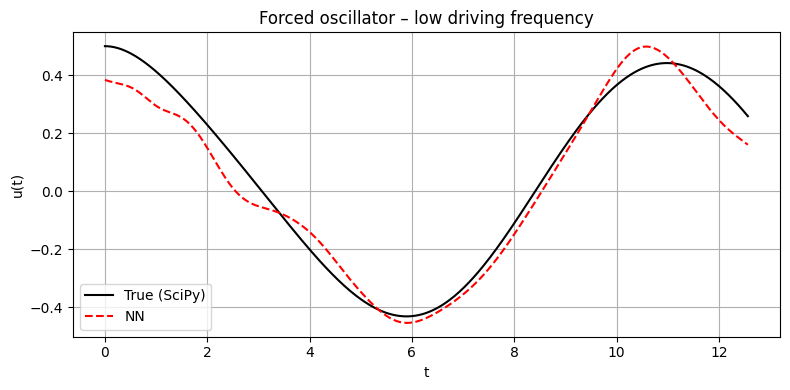

In [11]:
# Low driving frequency, modest forcing
test_forced_system(
    u0_test=0.5,
    v0_test=0.0,
    w0_test=1.2,
    gamma_test=0.3,
    F_test=0.5,
    Omega_test=0.6,
    title="Forced oscillator – low driving frequency"
)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


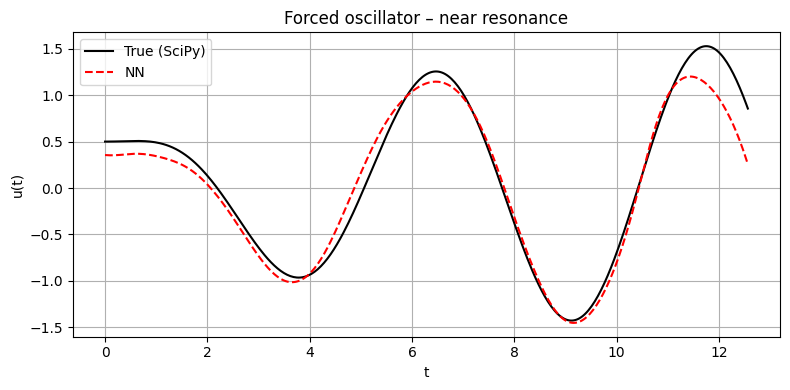

In [12]:
# Near resonance driving frequency
test_forced_system(
    u0_test=0.5,
    v0_test=0.0,
    w0_test=1.2,
    gamma_test=0.2,
    F_test=0.8,
    Omega_test=1.2,   # ~w0
    title="Forced oscillator – near resonance"
)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


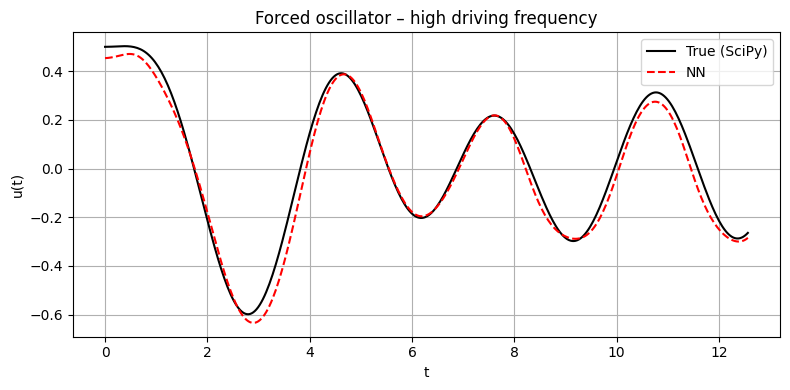

In [13]:
# High driving frequency
test_forced_system(
    u0_test=0.5,
    v0_test=0.0,
    w0_test=1.2,
    gamma_test=0.3,
    F_test=0.8,
    Omega_test=2.0,
    title="Forced oscillator – high driving frequency"
)